# CP (Constraint Programming)

### Imports and preliminary functions

In [ ]:
%pip install ipympl

In [2]:
#basilar import and routing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import matplotlib.patches as mpatches
import os
import numpy as np
import matplotlib.image as mpimg
%matplotlib widget

std_path = os.path.join(
    os.path.dirname('__file__'),
    'CP/out/out_data_std.csv'
)

max_path = os.path.join(
    os.path.dirname('__file__'),
    'CP/out/out_data_max.csv'
)

sbs_path = os.path.join(
    os.path.dirname('__file__'),
    'CP/out/out_data_sbs.csv'
)

In [5]:
#loading data info
std_data = pd.read_csv(std_path)
max_data = pd.read_csv(max_path)
sbs_data = pd.read_csv(sbs_path)

In [8]:
#creating color and patches (for chart legend) based on values (if the execution time is over 5 min the bar will be displayed in gray)
colors_std = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: '#522A27'}[True] for p in std_data["solve time"].to_list()]
colors_sbs = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: '#C73E1D'}[True] for p in sbs_data["solve time"].to_list()]
colors_max = [{p>=300: (0.5,0.5,0.5, 0.2), p<300: '#C59849'}[True] for p in max_data["solve time"].to_list()]
std_patch = mpatches.Patch(color='#522A27', label="Standard Solver")
max_patch = mpatches.Patch(color='#C59849', label="Boundary constraint solver")
sbs_patch = mpatches.Patch(color='#C73E1D', label="Simmetry breaking solver")
over5_patch = mpatches.Patch(color=(0.5,0.5,0.5,0.2), label="Over 5 min execution")

In [7]:
#calculating total and mean execution time for each solver
total_std_time = sum(std_data['solve time'].to_list())
total_max_time = sum(max_data['solve time'].to_list())
total_sbs_time = sum(sbs_data['solve time'].to_list())
mean_std = total_std_time/40
mean_max = total_max_time/40
mean_sbs = total_sbs_time/40


## Introduction


This section of the project is dedicated to the resolution of the VLSI **(Very Large Scale Integration)** problem throught CP **(Constraint Programming)**, in particular with the use of *Minizinc* constraint programming language.
The first thing we want to do is to formalize our problem into a more solid mathematical structure in order to have all the information needed to describe all the possible constraint appliable to it. A VLSI problem is defined, in our formulation, by four main elements:

- $w$ which represents the plate width
- $n$ which represents the number of chips to place on the plate
- $widths$ the widths of the chips. Since $widths$ is an array of element we're refering $widths_i$ as the width of the $i-th$ chip
- $heights$ the heights of the chips. Again, we're refering $heights_i$ as the height of the $i-th$ chip

Those four elements are the instances of our problem, the input element that the solver needs to analyze in order to find a solution. One more thing we need to do is to represent the output variable and their domains

#### **Plate height**
$h$ represent the estimated height of the plate. The domain of this variable is more complicated to exploit since it represent the actual value we want to minimize. We found different possibilities and, in the end, choose the best performing one:

- **Lower Bound**:
    - *Maximum of chips heights*: one possibility is to set the minimum height to the maximum over the chips heights. This definition clearly holds, cause plate heigth could never be smaller than the highest chip, but is not really time effective cause, generally, the minimum height of the plate is bigger and this leads to a bigger domain for the variable.

    - *Weighted Height*: Considering the constraint over the plate width, we could conclude that the minimum height of the plate is a direct function of the widths of the chips. A possible solution for the minimum height, so, is to consider the ration between the widht of the $i-th$ chip and the plate width as follows:
    \begin{equation*}
    ratio_i = \frac{widths_i}{w}
    \end{equation*}
    and then consider the sum of the weighted heights:
    \begin{equation}
    min_h = \sum_{i=0}^{n} heights_i \cdot ratio_i
    \end{equation}
    This solution gives results much closer to the actual height.

    - *Height of the total area*: another possibility is to consider the minimum possible height as the height of the rectangle that has exactly the same area of the sum of the chips's areas, formally:
    \begin{equation*}
    min_h = \frac{\sum_{i=0}^{n} widths_i \cdot heights_i}{w}
    \end{equation*}
    This definition is actually equivalent to one given before (we could derive one from the other), but it's much simpler to implement, so we decided to choose this one

- **Upper Bound**
  We actually have less opportunity around the upperbound. For sure we know that the maximum obtainable height, in the case of all pieces stacked togheter, is the sum of all the chips's heights. We could try to limit the maximum height, again, based on the width of the various pieces (we reach the maximum height only if all the chips have a width which is exclusive bigger than the plate width), but none of them seemed to be effetive in any ways



#### **Position x**
$x$ represents the bottom left x coordinates of the chips. Even in this case $x$ represents an array of all the position of the chips, so we're referring $x_i$ as the position of the $i-th$ chip. 
The domain of this variable could be expressed as $(0, w)$, since the position x of any chip should not overlap the width of the plate. But, since all the chips have a specific width, we could reduce the domain to the set:

$(0, w-min(widths))$

because no chip are small enough to be placed in the $(w-min(widths), w)$ without overlapping the width boundary.


#### **Position y**
$y$ represent the bottom left y coordinates of the chips. Again $y$ represents an array of all the coordinates, so we're refering $y_i$ as the bottom left y coordinate of the $i-th$ chip. We apply the same reasoning we've seen before for the domain, so the $y$ domain is:

$(0, h-min(heights))$



## Standard Model (STD)


The first model we want to present is made using the simplest constraint logic possible. The aim of the solver is the fit a number $n$ of chips inside a plate of width $w$ in order to minimize the height of the plate. So, the basilar constraint are the following:

1. *Width constraint*: We want to impose that no chips are positioned such that the total width is larger then the plate width. We could formalize mathematically this constrint as follows:
\begin{equation*}
x_i \leq w-widths_i \land y_i \leq h - heights_i, \forall i \in [1,...,n]
\end{equation*}
This constraint impose the chips position to be always limited to the domain of the boundary limits


2. *No overlap constraint*: In this case we want to impose that all the chips should be placed in a free space, we don't want the chips to overlap each other. We could formalize this constraint as follows:
\begin{equation*}
(x_i + widths_i \leq x_j \lor x_j + widths_j \leq x_i) \lor (y_i + heights_i \leq y_j \lor y_j + heights_j \leq y_i), \forall i,j  
\end{equation*}


3. *Cumulative Constraint*: Considering the similarity between the VLSI problem and the *Scheduling Problem* we can consider using two additional constraint, the **cumulative** constraint. This contraint is formalized (in our specific case) as follows:
\begin{equation*}
\sum_{i | y_i \leq u \leq y_i + heights_i} widths_i \leq w, \forall u \in heights
\end{equation*}

\begin{equation*}
\sum_{i | x_i \leq u \leq x_i + widths_i} heights_i \leq h, \forall u \in widths
\end{equation*}

The Minizinc implementation of the first constraint is realtively easy, as reported in [standard solver](CP/solvers/MODEL_STD.mzn), we have:

**forall**(i in 1..n)(positions_x[i] <= w - widths[i] /\ positions_y[i] <= h - heights[i]);

The second constrint is a little bit more coplicated to implement. Likely, MiniZinc offers a global constrint that implements this predicate, as reported by the [minizinc documentation](https://www.minizinc.org/doc-2.3.0/en/lib-globals.html), the **diffn** global constraint. In this particular case we're using **diffn_nonstrict** which has the exact same properties of **diffn** but allow to place 0 area chips everywhere.

Again, for the third constraint, we have a built in predicate **cumulative**



## Boundary Checker Model (MAX)


In the **standard model** we were checking all the chips to be in the right place. But is it really necessary? One possible improvement of the model is not to check for all the chips positions, but to check only if the maximum right bottom element is still inside of the plate. In this way we are sure that no other chips could be over the boundary (cause they are all smaller then the one we checked) and we don't need to loop around them. Formally:

\begin{equation*}
max(y + heights) \leq h \land max(x + widths) \leq w
\end{equation*}

We can easily model this constraint in Minizinc, as reported in [Boundary Checker Model](CP/solvers/MODEL_MAX.mzn), as follows:

**max**(i in 1..n)(y_i + heights_i) <= h

**max**(i in 1..n)(x_i + widths_i) <= w


## Simmetry Breaking Model (SBS)


The last model we want to present is the **Simmetry Breaking Model**. Clearly this model introduce some *Simmetry Breaking Constraint*. Our problem has two main simmetry axes, one along the width and one along the hegiht. The two simmetries could be expressed as follows:

\begin{equation*}
x'_i = (-x_i + 2w - widths_i) - w = w - x_i - widths_i
\end{equation*}

\begin{equation*}
y'_i = (-y_i + 2h - heights_i) - h = h - y_i - heights_i
\end{equation*}

and implemented in Minizinc, as reported in [Simmetry Breaking Model](CP/solvers/MODEL_SBS.mzn).

## Solvers Comparisons

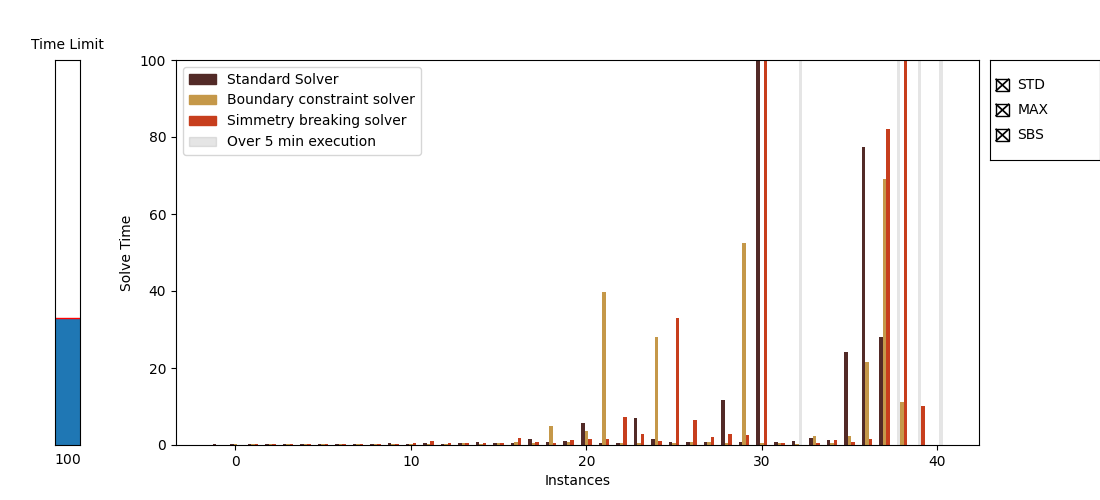

In [15]:
#interactive chart 1
width=0.2
fig, ax = plt.subplots(figsize=(11,5))
fig.set_label("Solving time comparisons between solvers")

index = np.arange(40)
ax.bar(index- width -1, std_data['solve time'].to_list(), width, color=colors_std, label="STD")
ax.bar(index, max_data['solve time'].to_list(), width, color=colors_max, label="MAX")
ax.bar(index + width +1, sbs_data['solve time'].to_list(), width, color=colors_sbs, label="SBS")


ax_checks = fig.add_axes([0.9, 0.68, 0.1, 0.2])
labels = [bar.get_label() for bar in ax.containers]
checks = widgets.CheckButtons(
    ax_checks,
    labels,
    [True, True, True]      
)

def checked(label):
    index = labels.index(label)
    for rect in ax.containers[index]:
        rect.set_visible(not rect.get_visible())   

checks.on_clicked(checked)


fig.subplots_adjust(left=0.16, right=0.89)

ax_ylim = fig.add_axes([0.05, 0.11, 0.0225, 0.77])
ylim_slider = widgets.Slider(
    ax=ax_ylim,
    label='Time Limit',
    valmin=2,
    valmax=300,
    valinit=100,
    orientation='vertical'
)

def update_slider(val):
    ax.set_ylim(0, ylim_slider.val)
    fig.canvas.draw_idle()

ylim_slider.on_changed(update_slider)

ax.set_ylabel("Solve Time")
ax.set_xlabel("Instances")
ax.set_ylim(0,100)
ax.legend(handles=[std_patch, max_patch, sbs_patch, over5_patch])

plt.show()

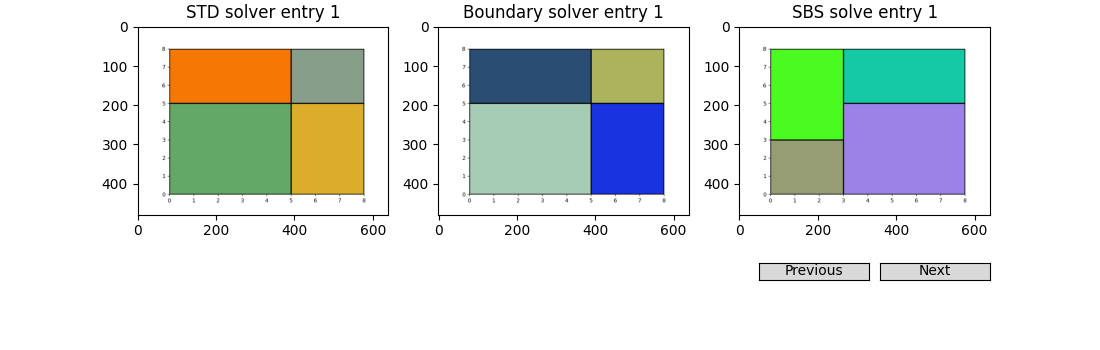

In [14]:
fig, ax = plt.subplots(1,3, figsize=(11,3.5))
fig.set_label("Solutions visualization")
fig.subplots_adjust(top=1.2)
img1 = mpimg.imread("CP/img/STD_IMG/device-1.png")
ax[0].imshow(img1)
ax[0].set_title("STD solver entry 1")

img2 = mpimg.imread("CP/img/MAX_IMG/device-1.png")
ax[1].imshow(img2)
ax[1].set_title("Boundary solver entry 1")

img3 = mpimg.imread("CP/img/SBS_IMG/device-1.png")
ax[2].imshow(img3)
ax[2].set_title("SBS solve entry 1")


prev_ax = fig.add_axes([0.69,0.2,0.1,0.05])
next_ax = fig.add_axes([0.8,0.2,0.1,0.05])
prev_button = widgets.Button(prev_ax, "Previous")
next_button = widgets.Button(next_ax, "Next")

class Index:
    ind = 1

    def next(self, event):
        if self.ind != 40:
            self.ind += 1
            img1 = mpimg.imread("CP/img/STD_IMG/device-" + str(self.ind) + ".png")
            ax[0].imshow(img1)
            ax[0].set_title("STD solver entry {}".format(self.ind))

            img2 = mpimg.imread("CP/img/MAX_IMG/device-" + str(self.ind) + ".png")
            ax[1].imshow(img2)
            ax[1].set_title("Boundary solver entry {}".format(self.ind))

            img3 = mpimg.imread("CP/img/SBS_IMG/device-" + str(self.ind) + ".png")
            ax[2].imshow(img3)
            ax[2].set_title("SBS solver entry {}".format(self.ind))
        

    def prev(self, event):
        if self.ind != 1:
            self.ind -= 1
            img1 = mpimg.imread("CP/img/STD_IMG/device-" + str(self.ind) + ".png")
            ax[0].imshow(img1)
            ax[0].set_title("STD solver entry {}".format(self.ind))

            img2 = mpimg.imread("CP/img/MAX_IMG/device-" + str(self.ind) + ".png")
            ax[1].imshow(img2)
            ax[1].set_title("Boundary solver entry {}".format(self.ind))

            img3 = mpimg.imread("CP/img/SBS_IMG/device-" + str(self.ind) + ".png")
            ax[2].imshow(img3)
            ax[2].set_title("SBS solver entry {}".format(self.ind))


   
callback = Index()
prev_button.on_clicked(callback.prev)
next_button.on_clicked(callback.next)
plt.show()
